# Figure 3A: swimmer plot
This notebook generates a swimmer plot for the entire paired cohort (n = 26 participants). This plot shows treatment and sampling timelines for each participant.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.colors as mpcolor
import matplotlib.cm as cm
import palettable
from matplotlib.lines import Line2D
from brokenaxes import brokenaxes

# Colors

In [2]:
cmap = palettable.cartocolors.qualitative.Prism_10.mpl_colors

# Helper functions to process input

In [3]:
def treatment_process(filename):
    df = pd.read_excel(filename)
    participant_val = df['participant_id'].tolist()
    treatment_val = df['Updated Categories for swimmer plots'].str.strip().tolist()
    tx_start = df['Start_date_DFD'].tolist()
    tx_end = df['Stop_date_DFD'].tolist()

    tx_mapping = {'HER2 targeted therapy + chemo': 'HER2-targeted therapy ± chemo',
                  'HER2 targeted therapy + ET': 'HER2-targeted therapy + ET ± chemo',
                  'HER2 targeted therapy': 'HER2-targeted therapy ± chemo',
                  'TKI + chemo': 'Anti-HER2 TKI ± chemo',
                  'TKI + ET': 'Anti-HER2 TKI + ET ± chemo',
                  'TKI': 'Anti-HER2 TKI ± chemo',
                  'TKI + HER2 targeted therapy': 'Anti-HER2 TKI + other HER2-targeted therapy',
                  'Chemotherapy': 'Chemotherapy (chemo)',
                  'Endocrine therapy (ET)': 'Endocrine therapy (ET)',
                  'Other targeted therapy': 'Other targeted therapy'
                  }

    new_dict = {'participant': participant_val,
                'treatment': list(map(tx_mapping.get, treatment_val)),
                'tx_start': tx_start,
                'tx_end': tx_end}

    return new_dict

def sample_process(filename):
    df = pd.read_csv(filename, sep='\t')
    participant_val = df['participant_id'].tolist()
    data_val = df['submitted_material_type'].tolist()
    time_from_tki_start = df['time_from_sampled_tki'].tolist()
    time_tki_start = df['sampled_tki_start_dfd'].tolist()

    new_dict = {'participant': participant_val,
                'data_type': data_val,
                'time_from_tki_start': time_from_tki_start,
                'time_tki_start': time_tki_start}

    return new_dict

def os_process(filename):
    df = pd.read_csv(filename, sep='\t')
    participant_val = df['participant_id'].tolist()
    os_val = df['os_met_dfd'].tolist()
    vital_status = df['vital_status'].tolist()

    new_dict = {'participant': participant_val,
                'os': os_val,
                'vital_status': vital_status}
    
    return new_dict

def generate_participantYpos(participant_df):
    participant_ids = list(participant_df['participant'])
    y_pos = {}
    new_pos = 0

    for id in participant_ids:
        if id not in y_pos:
            new_pos += 0.25
            y_pos[id] = new_pos

    return y_pos

# Load inputs

- Map ONC IDs to manuscript IDs
- Center times relative to TKI start
- Merge samples collected within x days of each other (x = 60 for now; arbitrary cutoff)

In [4]:
treatment_data = pd.DataFrame(treatment_process('data/tx_categories_for_swimmer_plots.xlsx'))
sample_data = pd.DataFrame(sample_process('data/paired_sample_cohort_sheet.txt'))
os_data = pd.DataFrame(os_process('data/paired_participant_cohort_sheet.txt'))
onc_id_mapping = pd.read_csv('data/ONC_ID_to_Manuscript_ID_mapping_paired.txt', sep='\t')
onc_id_mapping = dict(zip(onc_id_mapping['ONC ID'], onc_id_mapping['Manuscript ID']))

In [5]:
treatment_data['participant'] = treatment_data['participant'].map(onc_id_mapping)
sample_data['participant'] = sample_data['participant'].map(onc_id_mapping)
os_data['participant'] = os_data['participant'].map(onc_id_mapping)

In [6]:
treatment_data = treatment_data.loc[(treatment_data['tx_start'] != 'Unknown') & (treatment_data['tx_end'] != 'Unknown'), :]
treatment_data = treatment_data.merge(sample_data[['participant', 'time_tki_start']].drop_duplicates(), how = 'left', on = 'participant')
treatment_data['tx_start_centered'] = treatment_data['tx_start'] - treatment_data['time_tki_start']
treatment_data['tx_end_centered'] = treatment_data['tx_end'] - treatment_data['time_tki_start']

In [7]:
os_data = os_data.merge(sample_data[['participant', 'time_tki_start']].drop_duplicates(), how = 'left', on = 'participant')
os_data['os_centered'] = os_data['os'] - os_data['time_tki_start']

In [8]:
sample_merge_days = 60

sample_data = sample_data.sort_values(by = ['participant', 'time_from_tki_start'])
sample_data['group'] = sample_data.groupby('participant')['time_from_tki_start'].apply(lambda x: x.diff().gt(sample_merge_days).cumsum())
sample_data = sample_data.groupby(['participant','group']).agg(
    data_type_merged = ('data_type', lambda x: ''.join(sorted(list(x)))),
    time_from_tki_start_merged = ('time_from_tki_start', 'min')
).reset_index(level=1).reset_index()

/var/folders/x8/btckj2bs3xz_ktydlhbzstb40000gq/T/ipykernel_90350/1149088827.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sample_data['group'] = sample_data.groupby('participant')['time_from_tki_start'].apply(lambda x: x.diff().gt(sample_merge_days).cumsum())


# Formatting setup

In [9]:
participant_pos = dict(zip([f'Pt {i}' for i in range(treatment_data['participant'].nunique(), 0, -1)],
                           np.arange(start = 0.25, stop = (treatment_data['participant'].nunique() + 2) * 0.25, step = 0.25)))

tx_color = {'Chemotherapy (chemo)': '#808080',
            'Endocrine therapy (ET)': '#442259',
            'HER2-targeted therapy ± chemo': cmap[1],
            'HER2-targeted therapy + ET ± chemo': cmap[2],
            'Other targeted therapy': cmap[3],
            'Anti-HER2 TKI ± chemo': cmap[5],
            'Anti-HER2 TKI + ET ± chemo': cmap[6],
            'Anti-HER2 TKI + other HER2-targeted therapy': cmap[7]}

treatment = treatment_data['treatment'].unique()
participants = treatment_data['participant'].unique()

sample_marker = {'plasma': '.', 'tissue': 'v', 'Dead': 'x', 'Alive': '|'}

# Create plot

<Figure size 640x480 with 0 Axes>

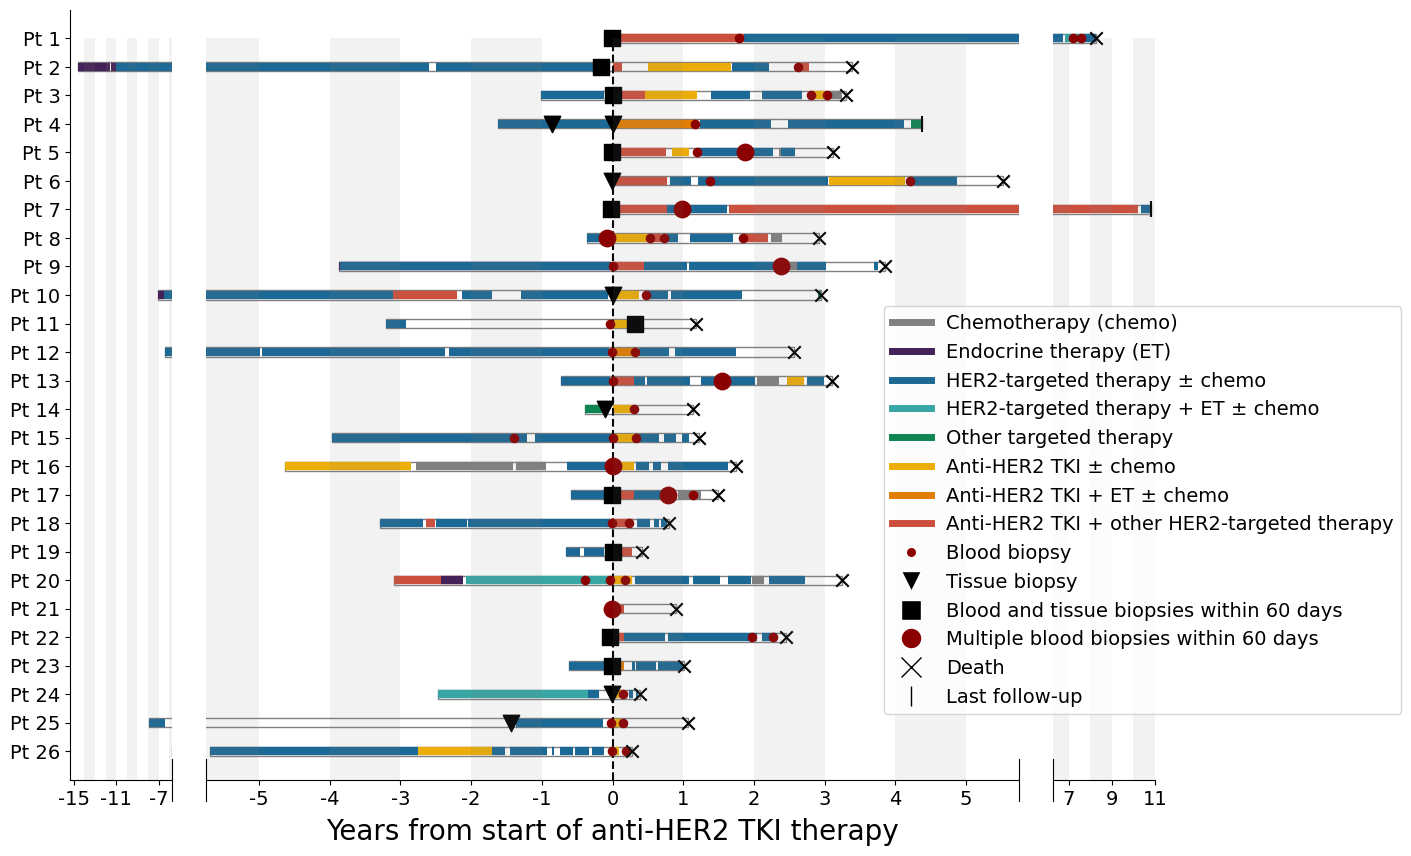

In [10]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['svg.fonttype'] = 'none'

plt.clf()
f = plt.figure(figsize = (14,10))
ax = brokenaxes(xlims=((-5600, -2101), (-2100, 2100), (2300, 4000)), wspace=0.1, width_ratios=[1,8,1], tilt=90)

# Plot treatments
for i, row in treatment_data.iterrows():
    y_pos = participant_pos[row['participant']]
    ax.hlines(y_pos,
             float(row['tx_start_centered']),
             float(row['tx_end_centered']),
             colors = tx_color[row['treatment']],
             linewidths = 6,
             zorder = -1,
             label = str(row['treatment']))

# Plot samples
offset = 0.0
for i, row in sample_data.iterrows():
    y_pos = participant_pos[row['participant']] + offset
    if row['data_type_merged'] == 'tissue':
        ax.scatter(float(row['time_from_tki_start_merged']),
                   y_pos,
                   marker = 'v',
                   c = 'k',
                   s = 140,
                   zorder = 1,
                   label = row['data_type_merged'])
    if row['data_type_merged'] == 'plasma':
        ax.scatter(float(row['time_from_tki_start_merged']),
                   y_pos,
                   marker = '.',
                   c = 'darkred',
                   s = 140,
                   zorder = 1,
                   label = row['data_type_merged'])
    if row['data_type_merged'] in ['plasmatissue', 'plasmaplasmaplasmatissue']:
        ax.scatter(float(row['time_from_tki_start_merged']),
                   y_pos,
                   marker = 's',
                   c = 'k' ,
                   s = 140,
                   zorder = 1,
                   label = row['data_type_merged'])
    if row['data_type_merged'] in ['plasmaplasma', 'plasmaplasmaplasma', 'plasmaplasmaplasmaplasma']:
        ax.scatter(float(row['time_from_tki_start_merged']),
                   y_pos,
                   marker = 'o',
                   c = 'darkred',
                   s = 140,
                   zorder = 1,
                   label = row['data_type_merged'])

# Plot OS + vital status
for i, row in os_data.iterrows():
    y_pos = participant_pos[row['participant']]
    if row['vital_status'] == 'Dead':
        ax.scatter(float(row['os_centered']),
                   y_pos,
                   marker = 'x',
                   c = 'k',
                   s = 80,
                   zorder = 1,
                   label = row['vital_status'])
    if row['vital_status'] == 'Alive':
        ax.scatter(float(row['os_centered']),
                   y_pos,
                   marker = '|',
                   c = 'k',
                   s = 140,
                   zorder = 1,
                   label = row['vital_status'])

# Plot rectangle from leftmost to rightmost extremes of bars for each participant
for i, row in os_data.iterrows():
    pt = row['participant']
    min_date = treatment_data.loc[treatment_data['participant'] == pt, 'tx_start_centered'].min()
    max_date = row['os_centered']
    y_pos = participant_pos[pt]

    ax.axs[0].add_patch(mpatches.Rectangle((min_date, y_pos - 0.04), max_date - min_date, 0.08, fc = 'none', ec = 'gray', lw = 1, zorder = -2))
    ax.axs[1].add_patch(mpatches.Rectangle((min_date, y_pos - 0.04), max_date - min_date, 0.08, fc = 'none', ec = 'gray', lw = 1, zorder = -2))
    ax.axs[2].add_patch(mpatches.Rectangle((min_date, y_pos - 0.04), max_date - min_date, 0.08, fc = 'none', ec = 'gray', lw = 1, zorder = -2))

# Start of sampled TKI
ax.vlines(0, 0, max(participant_pos.values()), color = 'k', linestyles = '--', zorder = -1)

ax.set_ylim((0, max(participant_pos.values()) + 0.25))
ax.axs[0].set_yticks(list(participant_pos.values()))
ax.axs[0].set_yticklabels(list(participant_pos.keys()))

# Labels
m = 365

x_ticks_0 = list(range(-15*m, -2000, 4*m))
x_ticks_0_label=np.array(x_ticks_0)/m
ax.axs[0].set_xticks(x_ticks_0)
ax.axs[0].set_xticklabels(x_ticks_0_label.astype(int), fontsize=14)

x_ticks_1 = list(range(-5*m, 6*m, m))
x_ticks_1_label=np.array(x_ticks_1)/m
ax.axs[1].set_xticks(x_ticks_1)
ax.axs[1].set_xticklabels(x_ticks_1_label.astype(int), fontsize=14)

x_ticks_2 = list(range(7*m, 12*m, 2*m))
x_ticks_2_label=np.array(x_ticks_2)/m
ax.axs[2].set_xticks(x_ticks_2)
ax.axs[2].set_xticklabels(x_ticks_2_label.astype(int), fontsize=14)

ax.big_ax.set_xlabel('Years from start of anti-HER2 TKI therapy', fontsize=20, labelpad=24)

# Plot shading for every other year
counter=0
for i in range(-15*m, -2101, m):
    counter=counter+1

    #Ignore every other year for the patches
    if counter % 2 == 1: continue

    newpatch=mpatches.Rectangle([i, 0], m, max(participant_pos.values()), ec='none',color='gray', alpha=0.1)
    ax.axs[0].add_patch(newpatch)

counter=0
for i in range(-6*m, 6*m, m):
    counter=counter+1

    #Ignore every other year for the patches
    if counter % 2 == 0: continue

    newpatch=mpatches.Rectangle([i, 0], m, max(participant_pos.values()), ec='none',color='gray', alpha=0.1)
    ax.axs[1].add_patch(newpatch)

counter=0
for i in range(6*m, 12*m, m):
    counter=counter+1

    #Ignore every other year for the patches
    if counter % 2 == 0: continue

    newpatch=mpatches.Rectangle([i, 0], m, max(participant_pos.values()), ec='none',color='gray', alpha=0.1)
    ax.axs[2].add_patch(newpatch)

# Add treatments to legend
legend_elements = []
for tx in tx_color:
    new_legend = Line2D([0], [0], color = tx_color[tx], lw = 5, label = tx)
    legend_elements.append(new_legend)

# Add samples to legend
legend_elements.append(Line2D([0], [0], marker = '.', color = 'w', label = 'Blood biopsy', markerfacecolor = 'darkred', markersize = 15))
legend_elements.append(Line2D([0], [0], marker = 'v', color = 'w', label = 'Tissue biopsy', markerfacecolor = 'k', markersize = 15))
legend_elements.append(Line2D([0], [0], marker = 's', color = 'w', label = f'Blood and tissue biopsies within {sample_merge_days} days', markerfacecolor = 'k', markersize = 15))
legend_elements.append(Line2D([0], [0], marker = 'o', color = 'w', label = f'Multiple blood biopsies within {sample_merge_days} days', markerfacecolor = 'darkred', markersize = 15))
legend_elements.append(Line2D([0], [0], marker = 'x', label = 'Death', ls = 'None', markeredgecolor = 'k', markersize = 15))
legend_elements.append(Line2D([0], [0], marker = '|', label = 'Last follow-up', ls = 'None', markeredgecolor = 'k', markersize = 15))

ax.big_ax.legend(handles = legend_elements, bbox_to_anchor=(0.75, 0.35), loc = 'center left', borderaxespad = 0)

plt.show()